In [21]:
from gdc.data_access import *
from gdc.pricing import *
from gdc.utils import GDC_DATA_PATH
import pandas as pd
from os import path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
df_load_simulated_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2023-01-01 00:00:00,0.308875,0.241084,0.435789,0.424829,0.239696,0.618679,0.201332,0.002316,0.537362,0.863129,...,0.848488,0.609326,0.750540,0.509708,0.675622,0.224907,1.116675,0.979219,1.214080,1.667707
2023-01-01 01:00:00,0.325552,0.246717,0.424862,0.387153,2.523461,0.619000,0.220604,1.393032,1.130548,0.721798,...,6.277924,0.935558,0.704712,0.445823,0.709091,0.192008,1.053277,0.809944,1.277540,5.152804
2023-01-01 02:00:00,3.468337,0.245007,2.300304,0.389507,0.987357,2.315828,2.433891,0.151374,0.877162,0.589248,...,1.191456,1.541097,0.711532,0.605748,0.757926,0.215429,0.839848,0.714650,1.375509,6.028554
2023-01-01 03:00:00,2.215840,1.272533,2.411101,0.382058,0.542293,1.898651,0.208088,0.123750,0.581648,0.515496,...,1.093116,1.073977,0.719326,1.533871,0.714349,0.228124,0.816399,1.518087,2.130233,4.159936
2023-01-01 04:00:00,1.259481,1.027133,0.483457,0.393334,0.380745,2.999703,0.152132,0.158867,1.667804,0.507242,...,1.070443,0.826959,0.757065,0.524391,0.865323,0.203812,0.809643,0.820883,6.877547,3.808041


In [23]:
df_hourly_prices.head()

,Price_EUR_MWh
date,
2023-01-01 00:00:00,-0.10
2023-01-01 01:00:00,-1.33
2023-01-01 02:00:00,-4.08
2023-01-01 03:00:00,-4.16
2023-01-01 04:00:00,-3.58


<Axes: xlabel='date'>

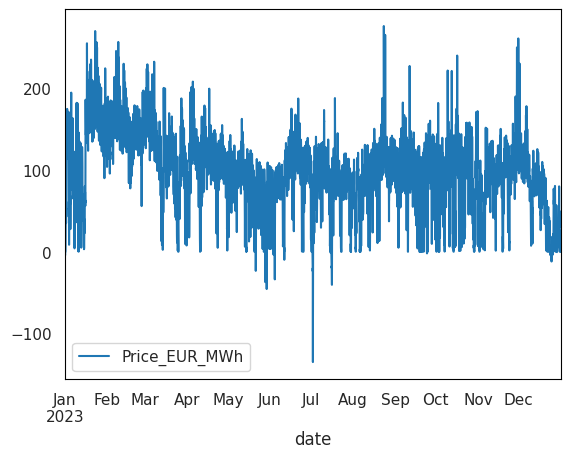

In [24]:
df_hourly_prices.plot()

In [25]:
dic_profits_by_power = {}

for p in [6, 9, 12]:
    this_loads = df_load_simulated_normalized.loc[:, get_subscribers(p)]
    dic_profits_by_power[p] = compute_simulated_base_variable_profit_ht(p, this_loads, df_hourly_prices)

<Axes: >

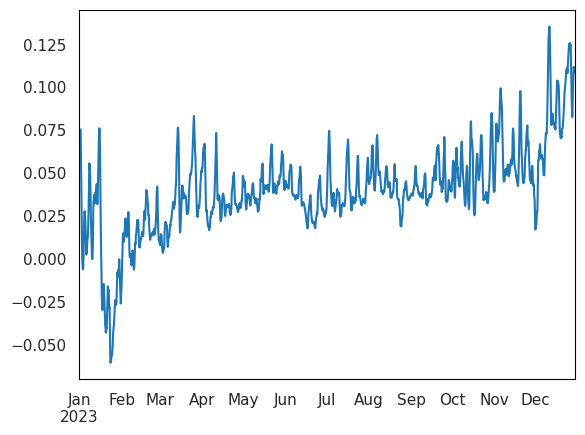

In [71]:
profits_6 = dic_profits_by_power[6]

agg_profit = profits_6.mean(axis=1)
agg_profit.rolling(24).mean().plot()

### population quantile as predicted profit

/home/sylvain857/.virtualenvs/py311-gdc/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


profit 1166187.364502724
raw delta pi -250554.83271295627
clipped_error 90357.72884040509
cost/profit 0.07748131354427312


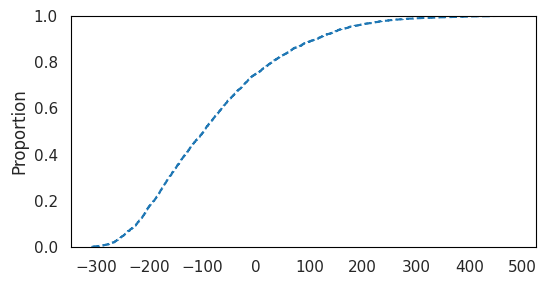

In [64]:
q = .75
quantile_profits = predicted_moments(profits_6, df_temp_simulated_normalized, 'quantile', q)

prediction_error = (profits_6 - quantile_profits).sum(axis=0)

plt.figure(figsize =(6,3))
sns.ecdfplot(prediction_error)

raw_prediction_error = prediction_error.sum()
total_profits = profits_6.sum().sum()
clipped_errors = prediction_error.clip(0).sum()
print("profit {}\n" 
    "raw delta pi {}\n" 
    "clipped_error {}\ncost/profit {}".format(
        total_profits, raw_prediction_error, clipped_errors,clipped_errors/total_profits
    )
)

### mean inflator

profit 1166187.364502724
raw delta pi -583093.6822513614
clipped_error 32351.510038565742
cost/profit 0.027741262702122318


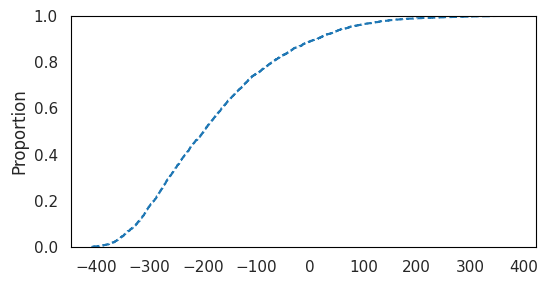

In [65]:
coef = 1.5
mean_profits = predicted_moments(profits_6, df_temp_simulated_normalized, 'mean')

prediction_error = (profits_6 - coef * mean_profits).sum(axis=0)

plt.figure(figsize =(6,3))
sns.ecdfplot(prediction_error)

raw_prediction_error = prediction_error.sum()
total_profits = profits_6.sum().sum()
clipped_errors = prediction_error.clip(0).sum()
print("profit {}\n" 
    "raw delta pi {}\n" 
    "clipped_error {}\ncost/profit {}".format(
        total_profits, raw_prediction_error, clipped_errors,clipped_errors/total_profits
    )
)

### Individualized means

<Axes: >

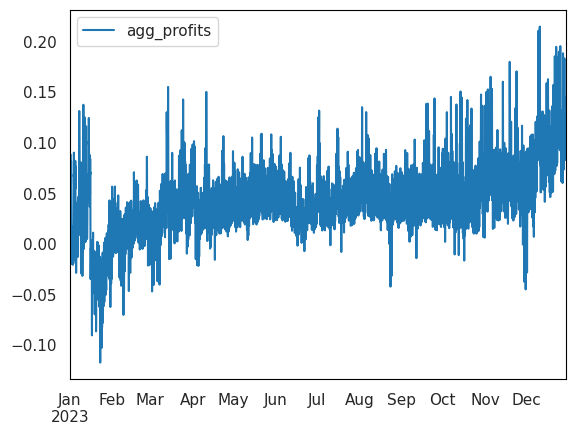

In [66]:
agg_profit.plot()

In [82]:
relative_profitability = profits_6.rolling(7 * 24).mean().div(np.abs(agg_profit.rolling(7 * 24).mean())+ .001, axis=0)

<Axes: >

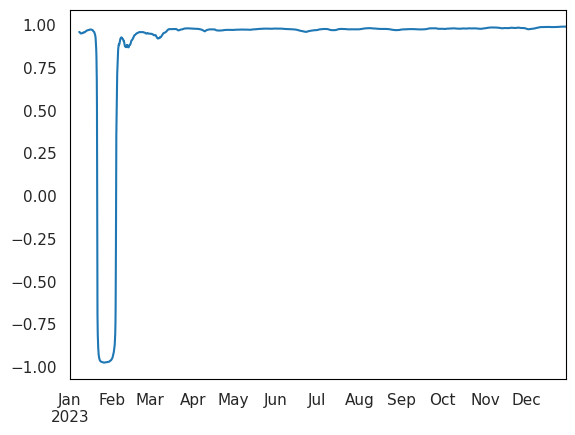

In [84]:
relative_profitability.mean(axis=1).plot()

In [85]:
relative_profitability.shift(1)

,0,1,2,3,4,5,6,7,8,9,...,9894,9895,9896,9897,9898,9899,9900,9901,9902,9903
2023-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 19:00:00,1.183863,0.696265,0.933922,1.262327,0.729057,1.306297,0.504351,0.626901,0.998151,1.864676,...,1.825014,1.320896,1.967576,0.960189,1.012705,1.477250,1.360953,0.844864,1.062928,0.980040
2023-12-29 20:00:00,1.183162,0.698546,0.933632,1.259529,0.727831,1.301059,0.519735,0.626131,0.991278,1.872186,...,1.815097,1.318444,1.969150,0.962040,1.011568,1.477378,1.357923,0.834839,1.061687,0.980666
2023-12-29 21:00:00,1.173940,0.698649,0.932360,1.260546,0.725644,1.303539,0.519290,0.625950,0.988624,1.880904,...,1.811342,1.316675,1.970093,0.963432,1.016712,1.477628,1.355747,0.820849,1.058764,0.981058
2023-12-29 22:00:00,1.171455,0.698822,0.929657,1.258013,0.724736,1.312993,0.520908,0.626141,0.986233,1.896170,...,1.809713,1.314836,1.971356,0.966515,1.019974,1.476171,1.354232,0.805391,1.049724,0.981508


In [86]:
predicted_profitability = relative_profitability.shift(1).mul(np.abs(agg_profit.rolling(7 * 24).mean())+ .001, axis=0)
predicted_profitability

,0,1,2,3,4,5,6,7,8,9,...,9894,9895,9896,9897,9898,9899,9900,9901,9902,9903
2023-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 19:00:00,0.132174,0.077735,0.104269,0.140934,0.081397,0.145843,0.056309,0.069991,0.111440,0.208184,...,0.203756,0.147473,0.219673,0.107202,0.113065,0.164929,0.151945,0.094326,0.118672,0.109418
2023-12-29 20:00:00,0.132117,0.078003,0.104253,0.140645,0.081273,0.145282,0.058036,0.069917,0.110691,0.209057,...,0.202682,0.147223,0.219884,0.107426,0.112956,0.164971,0.151632,0.093222,0.118553,0.109506
2023-12-29 21:00:00,0.131069,0.078004,0.104097,0.140739,0.081018,0.145539,0.057978,0.069887,0.110379,0.210001,...,0.202235,0.147006,0.219959,0.107566,0.113515,0.164976,0.151368,0.091647,0.118210,0.109534
2023-12-29 22:00:00,0.130735,0.077989,0.103750,0.140395,0.080881,0.146530,0.058133,0.069877,0.110064,0.211613,...,0.201965,0.146736,0.220004,0.107863,0.113829,0.164741,0.151133,0.089882,0.117150,0.109537
